<a href="https://colab.research.google.com/github/srananna/Edge-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model for Cyberattack Detection and Classification

In [4]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.3 MB/s eta 0:00:00


In [11]:
# Importing the required libraries and downloading stopwords packages.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Concatenate, Dropout, Flatten
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
import emoji
import ast
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

nltk.download('punkt','/usr/share/nltk_data')
# nltk.download('wordnet','/usr/share/nltk_data')
nltk.download('averaged_perceptron_tagger','/usr/share/nltk_data')
nltk.download('stopwords','/usr/share/nltk_data')

# It seems that ntlk.dowload() does not work on Kaggle even after specifying directory, so we are going to use a solution I found at https://www.kaggle.com/discussions/general/395169
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


# Data Handling and Preprocessing, Feature Extraction

In [12]:
# Load data from CSV file
data = pd.read_csv('/content/drive/MyDrive/tweets_final.csv')

# Data Preprocessing
# Data Cleaning
def clean_text(text):
    # Remove unnecessary characters
    text = re.sub(r'[^\w\s]', '', text)
    # Replace repetitive line breaks and blank spaces with only one
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove emoticons and emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    return text

data['text'] = data['text'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['text'] = data['text'].apply(lemmatize_text)

# POS Tagging
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

data['pos_tags'] = data['text'].apply(pos_tagging)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
X_seq = tokenizer.texts_to_sequences(data['text'])
X_pad = pad_sequences(X_seq, maxlen=100)

# Stopwords removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

data['text'] = data['text'].apply(remove_stopwords)

# Message Structure preprocessing
# Extract structural features (Table 1)
# Define the function to extract structural features (Table 1)
def extract_structural_features(text):
    # Implement feature extraction logic
    message_length = len(text)
    num_tokens = len(word_tokenize(text))
    num_hashtags = text.count('#')
    num_emails = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    num_urls = text.count('http://') + text.count('https://')
    num_periods = text.count('.')
    num_commas = text.count(',')
    num_digits = sum(c.isdigit() for c in text)
    num_sentences = len(sent_tokenize(text))
    num_mentioned_users = text.count('@')
    num_uppercase = sum(c.isupper() for c in text)
    num_question_marks = text.count('?')
    num_exclamation_marks = text.count('!')
    emojis = set(re.findall(r'\:[\w]+\:', emoji.demojize(text)))
    num_emoticons = len(emojis)
    num_dollar_symbols = text.count('$')
    # Other symbols
    num_other_symbols = len([char for char in text if char not in '"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!' + ''.join(emojis)])
    # Return features as a list
    return [message_length, num_tokens, num_hashtags, num_emails, num_urls, num_periods, num_commas, num_digits, num_sentences, num_mentioned_users, num_uppercase, num_question_marks, num_exclamation_marks, num_emoticons, num_dollar_symbols, num_other_symbols]

# Apply the function to extract structural features and create a new column
data['structural_features'] = data['text'].apply(extract_structural_features)

# Define the function to replace specific text components with predefined tokens
def replace_text_components(text):
    # Implement text component replacement logic
    # For example, replace email addresses with 'email_nlp', replace mentioned users with 'at_user_nlp', etc.
    # Here's a simple example:
    text = text.replace('@', 'at_user_nlp')
    text = text.replace('#', '')  # Remove hashtags
    # Add more replacement rules as needed
    return text

data['text'] = data['text'].apply(replace_text_components)

# Extract URL characteristics (Table 2) from the destination_url column
def extract_first_url(url_list):
    try:
        urls = ast.literal_eval(url_list)
        first_url = urls[0] if urls else None
        return first_url
    except (SyntaxError, ValueError):
        return None

def extract_url_features(url, urls):
    # Extract domain suffix and registrant from the URL
    if pd.isna(url):
        return ['NA'] * 24  # Return NA for all features if URL is missing
    else:
        url_length = len(url)
        has_security_protocol = 'Y' if url.startswith(('http://', 'https://')) else 'N'
        # Feature 3 and 4: Creation date and Last update date (Days) - Not implemented
        # Extract the first URL from the list
        first_url = extract_first_url(urls)
        is_shortened_url = 'Y' if first_url and len(url) < len(first_url) else 'N'
        strings_divided_by_periods = len(url.split('.'))
        strings_divided_by_hyphens = len(url.split('-'))
        strings_divided_by_slashes = len(url.split('/'))
        num_words = len(re.findall(r'\b\w+\b', url))
        num_ips = len(re.findall(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', url))
        num_digits = sum(c.isdigit() for c in url)
        num_hyphens = url.count('-')
        num_periods = url.count('.')
        num_slashes = url.count('/')
        num_uppercase = sum(c.isupper() for c in url)
        num_lowercase = sum(c.islower() for c in url)
        num_ampersand_symbols = url.count('&')
        num_equal_symbols = url.count('=')
        num_question_marks = url.count('?')
        num_wave_symbols = url.count('~')
        num_plus_signs = url.count('+')
        num_colon_symbols = url.count(':')
        num_other_characters = len([char for char in url if char not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@.://,?!-'])
        has_extension = 'Y' if '.' in url else 'N'
        domain_suffix = url.split('.')[-1]
        registrant = url.split('/')[2].split('.')[-2] if '/' in url else 'NA'
        return [url_length, has_security_protocol, is_shortened_url, strings_divided_by_periods, strings_divided_by_hyphens, strings_divided_by_slashes, num_words, num_ips, num_digits, num_hyphens, num_periods, num_slashes, num_uppercase, num_lowercase, num_ampersand_symbols, num_equal_symbols, num_question_marks, num_wave_symbols, num_plus_signs, num_colon_symbols, num_other_characters, has_extension, domain_suffix, registrant]

# Apply the function to the 'destination_url' column and create new columns for each feature
url_features = data.apply(lambda row: pd.Series(extract_url_features(row['destination_url'], row['urls'])), axis=1)
# Combine all details into a single DataFrame
url_features.columns = ['url_length', 'has_security_protocol', 'is_shortened_url', 'strings_divided_by_periods', 'strings_divided_by_hyphens', 'strings_divided_by_slashes', 'num_words', 'num_ips', 'num_digits', 'num_hyphens', 'num_periods', 'num_slashes', 'num_uppercase', 'num_lowercase', 'num_ampersand_symbols', 'num_equal_symbols', 'num_question_marks', 'num_wave_symbols', 'num_plus_signs', 'num_colon_symbols', 'num_other_characters', 'has_extension', 'domain_suffix', 'registrant']
data = pd.concat([data, url_features], axis=1)

url_features = data.apply(lambda row: pd.Series(extract_url_features(row['destination_url'], row['urls'])), axis=1)
url_features_df = pd.DataFrame(url_features.values, columns=['feature_{}'.format(i) for i in range(url_features.shape[1])])

# Replace specific URL components with predefined tokens
def replace_url_components(url):
    # Replace email addresses and mentioned users with predefined tokens
    replaced_url = re.sub(r'[\w\.-]+@[\w\.-]+', 'email_nlp', url)
    replaced_url = re.sub(r'@[\w\.-]+', 'at_user_nlp', replaced_url)
    return replaced_url

# Replace NaN values with an empty string in the 'destination_url' column
data['destination_url'].fillna('', inplace=True)
# Replace URL components with predefined tokens
data['resolved_urls'] = data['destination_url'].apply(replace_url_components)

# Input vectorization and train-test split

In [13]:
# Vectorization
# Hashing Vector for content
hashing_vectorizer = HashingVectorizer(n_features=100)
X_hash = hashing_vectorizer.fit_transform(data['text'])

# Text Structure Vector
X_text_structure = np.array(data['structural_features'].tolist())

url_features_lists = url_features_df.astype(str).apply(lambda row: row.tolist(), axis=1)

# Hash the combined features
hasher = FeatureHasher(n_features=1000, input_type='string')
X_url_structure_hashed = hasher.transform(url_features_lists)

# Convert hashed features to array
X_url_structure_hashed = X_url_structure_hashed.toarray()

# Convert labels to numerical values
label_dict = {'vulnerability': 0, 'ransomware': 1, 'ddos': 2, 'leak': 3, 'general': 4, '0day': 5, 'botnet': 6, 'all': 7}
y = np.array([label_dict[category] for category in data['type']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_train_hash, X_test_hash, _, _ = train_test_split(X_hash, y, test_size=0.2, random_state=42)
X_train_text_structure, X_test_text_structure, _, _ = train_test_split(X_text_structure, y, test_size=0.2, random_state=42)
X_train_url_structure, X_test_url_structure, _, _ = train_test_split(X_url_structure_hashed, y, test_size=0.2, random_state=42)

# Building the CNN architecture

In [14]:
# Build the CNN model
input_content = Input(shape=(100,), name='content_input')
input_text_structure = Input(shape=(16,), name='text_structure_input')
input_url_structure = Input(shape=(1000,), name='url_structure_input')

# Additional input layers for other features
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=100)(input_content)
conv_layer = Conv1D(128, 5, activation='relu')(embedding)
dropout_layer = Dropout(rate=0.5)(conv_layer)
pooling_layer = GlobalMaxPooling1D()(dropout_layer)
flattened_layer = Flatten()(pooling_layer)

# Concatenate all input layers
concatenated_inputs = Concatenate()([flattened_layer, input_text_structure, input_url_structure])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concatenated_inputs)
output = Dense(8, activation='softmax')(dense1)  # Output layer with 8 classes

# Define the model
model = Model(inputs=[input_content, input_text_structure, input_url_structure], outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    x=[X_train, X_train_text_structure, X_train_url_structure],
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(
        [X_test, X_test_text_structure, X_test_url_structure],
        y_test
    )
)

Epoch 1/5
535/535 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - accuracy: 0.7665 - loss: 0.7214 - val_accuracy: 0.9584 - val_loss: 0.1729
Epoch 2/5
535/535 ━━━━━━━━━━━━━━━━━━━━ 79s 85ms/step - accuracy: 0.9682 - loss: 0.1128 - val_accuracy: 0.9598 - val_loss: 0.1612
Epoch 3/5
535/535 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9827 - loss: 0.0540 - val_accuracy: 0.9647 - val_loss: 0.1587
Epoch 4/5
535/535 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - accuracy: 0.9906 - loss: 0.0313 - val_accuracy: 0.9497 - val_loss: 0.1953
Epoch 5/5
535/535 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.9951 - loss: 0.0161 - val_accuracy: 0.9600 - val_loss: 0.1704


# Model Evalution and Analysis

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9580 - loss: 0.2021
Test Loss: 0.17040663957595825, Test Accuracy: 0.9599906206130981


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ content_input             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │      4,569,800 │ content_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 96, 128)        │         64,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 96, 128)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ dropout[0][0]          │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_structure_input      │ (None, 16)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ url_structure_input       │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1144)           │              0 │ flatten[0][0],         │
│                           │                        │                │ text_structure_input[… │
│                           │                        │                │ url_structure_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        146,560 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8)              │          1,032 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,344,562 (54.72 MB)

 Trainable params: 4,781,520 (18.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,563,042 (36.48 MB)

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


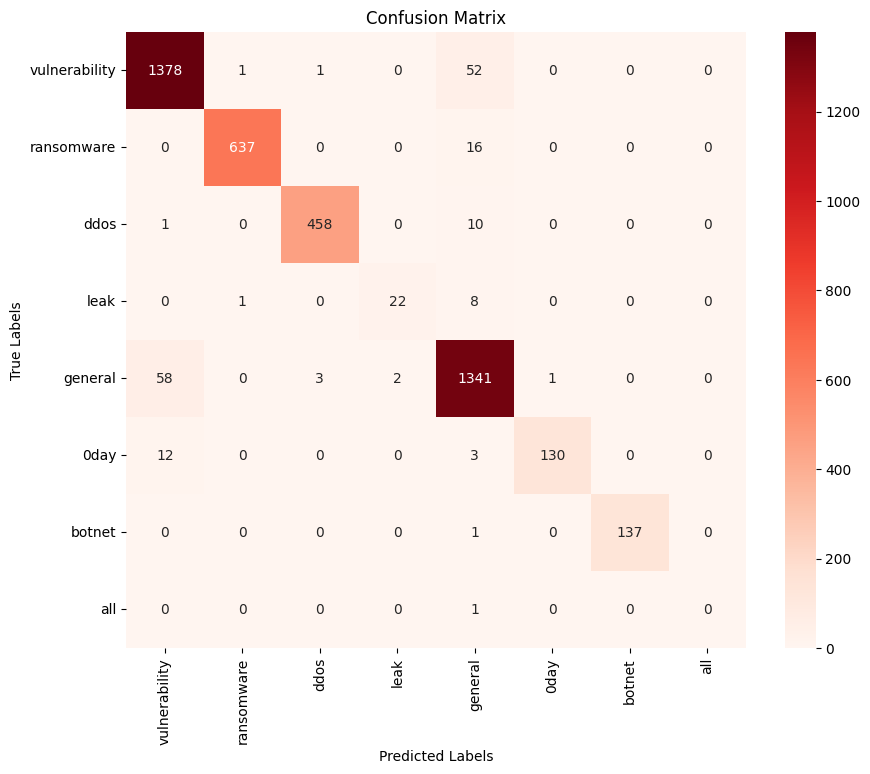

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test, X_test_text_structure, X_test_url_structure], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

model.summary()

# Make predictions on the test set
predictions = model.predict([X_test, X_test_text_structure, X_test_url_structure])
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()